### ***Neural Network Stock Movement Prediction***

This notebook demonstrates the implementation of a binary classifier for stock price movement prediction using our updated `mlp_classifier.py` module. The implementation has been enhanced to work with clustered features and includes comprehensive visualization capabilities.

### ***Prerequisites***

Before running this notebook:
1. Ensure the `cluster.csv` file is available in the data directory
2. Check that all required packages are installed

### ***Implementation Overview***

The updated `mlp_classifier.py` module provides:

1. Data Pipeline:
   - Loads enriched dataset from `cluster.csv`
   - Features include both PCA components and cluster assignments
   - Uses chronological train-test split (80-20)
   - No shuffling to maintain time series integrity

2. Model Architecture:
   - Three hidden layers: 128 → 64 → 32 neurons
   - ReLU activation functions
   - Adam optimizer with adaptive learning rate
   - Early stopping (patience: 10 epochs)
   - Validation fraction: 0.2 of training data
   - Batch size: 32

3. Output:
   - Saves training report to `figures/mlp_training_report.txt`
   - Generates visualizations in `figures/`
     * `mlp_training_history.png` - Training progress
     * `mlp_confusion_matrix.png` - Model evaluation
   - Returns plot paths dictionary for notebook rendering

### ***Implementation Summary***

The following implementation has been updated in this notebook:

1. Data Processing:
   - Uses `cluster.csv` data with both PCA components and cluster assignments
   - Implements chronological train-test split (80-20 split)
   - Converts multi-class labels to binary classification (significant upward movement vs. others)

2. Model Architecture:
   - MLPClassifier with three hidden layers: 128 → 64 → 32 neurons
   - ReLU activation functions
   - Adam optimizer with adaptive learning rate
   - Early stopping with patience of 10 epochs
   - Validation fraction: 0.2 of training data

3. Output and Visualizations:
   - Training report saved to `figures/mlp_training_report.txt`
   - Visualizations saved in `figures/` directory:
     * `mlp_training_history.png` - Combined loss and validation scores
     * `mlp_confusion_matrix.png` - Model evaluation
     * Individual loss curve and validation score plots
   - Metrics saved to `data/mlp_classifier_output/`

4. Integration:
   - Returns metrics, classification report, and plot paths
   - Ready for pipeline integration with comprehensive outputs

### ***MLP Classifier Results***

This notebook presents the results of our MLP Classifier trained on the clustered data from `cluster.csv`. The model uses both PCA components and cluster assignments to predict significant stock price movements, with comprehensive metrics and visualizations generated automatically.

### ***Neural Network Stock Movement Prediction***

This notebook demonstrates the usage of our neural network implementation from `mlp_classifier.py`. The module implements a binary classifier to predict significant stock price movements using scikit-learn's MLPClassifier.

### ***Prerequisites***

Before running this notebook:
1. Ensure the `cluster.csv` file is available in the data directory
2. Verify all clustering features have been generated
3. Check that all required packages are installed

### ***Implementation Overview***

The `mlp_classifier.py` module provides:

1. Data Pipeline:
   - Loads clustered features from `cluster.csv`
   - Converts to binary classification (1 for >1.5% increase, 0 otherwise)
   - Uses chronological train-test split (80-20)

2. Model Architecture:
   - Three hidden layers: 128 → 64 → 32 neurons
   - ReLU activation functions
   - Adam optimizer with adaptive learning rate
   - Early stopping for regularization

3. Output:
   - Saves metrics to `data/mlp_classifier_output/metrics.csv`
   - Saves detailed report to `figures/mlp_training_report.txt`
   - Generates visualizations in `figures/` directory
   - Returns metrics, classification report, and plot paths for pipeline integration

In [6]:
# Standard imports for visualization
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os

# Import our MLP classifier module
from mlp_classifier import train_and_evaluate
from config import OUTPUT_DIR, SCRIPT_DIR

# Set plotting style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [7]:
# Check prerequisites
from pathlib import Path

# Check if cluster features file exists
cluster_file = os.path.join(OUTPUT_DIR, "cluster.csv")
if not os.path.exists(cluster_file):
    raise FileNotFoundError(
        "\nERROR: Cluster features file not found!"
        "\nPlease ensure the cluster.csv file is available in:"
        f"\n{cluster_file}"
    )
else:
    print("✓ Cluster features file found")
    
# Create figures directory if needed
fig_dir = os.path.join(SCRIPT_DIR, "figures")
os.makedirs(fig_dir, exist_ok=True)
print("✓ Figures directory ready:", fig_dir)

# Create output directory if needed
output_dir = os.path.join(OUTPUT_DIR, "mlp_classifier_output")
os.makedirs(output_dir, exist_ok=True)
print("✓ Output directory ready:", output_dir)

✓ Cluster features file found
✓ Figures directory ready: g:\School\Data Mining Techniques\CS6220_final_project\figures
✓ Output directory ready: g:\School\Data Mining Techniques\CS6220_final_project\data\mlp_classifier_output


### ***Model Training and Evaluation***

Let's use the `train_and_evaluate()` function from our module to:
1. Load the PCA-transformed features
2. Train the neural network
3. Evaluate performance
4. Save results to the output directory

### ***Model Setup***

We'll create our neural network using scikit-learn's MLPClassifier. The architecture matches our proposal requirements:
- Three hidden layers for deep feature extraction
- ReLU activation for non-linearity
- Dropout and early stopping for regularization
- Adam optimizer for efficient training

In [8]:
# Display the model configuration used in mlp_classifier.py
from sklearn.neural_network import MLPClassifier

# This is the exact configuration used in our mlp_classifier.py
model_config = {
    'hidden_layer_sizes': (128, 64, 32),  # Three hidden layers
    'activation': 'relu',                 # ReLU activation function
    'solver': 'adam',                     # Adam optimizer
    'alpha': 0.0001,                      # L2 regularization term
    'batch_size': 32,                     # Batch size for training
    'learning_rate': 'adaptive',          # Adaptive learning rate
    'max_iter': 1000,                     # Maximum iterations
    'early_stopping': True,               # Enable early stopping
    'validation_fraction': 0.2,           # 20% of training data for validation
    'n_iter_no_change': 10,               # Patience for early stopping
    'verbose': True                       # Show training progress
}

print("MLP Classifier Configuration:")
print("=" * 50)
for param, value in model_config.items():
    print(f"{param:>20}: {value}")

print("\nModel Architecture:")
print("=" * 50)
print("Input Layer    → Features from cluster.csv (PCA components + cluster labels)")
print("Hidden Layer 1 → 128 neurons (ReLU activation)")
print("Hidden Layer 2 → 64 neurons  (ReLU activation)")
print("Hidden Layer 3 → 32 neurons  (ReLU activation)")
print("Output Layer   → 2 neurons   (Binary classification)")

# Create a sample model instance to show the structure
sample_model = MLPClassifier(**model_config)
print(f"\nModel Type: {type(sample_model).__name__}")
print(f"Hidden Layers: {sample_model.hidden_layer_sizes}")
print(f"Activation: {sample_model.activation}")
print(f"Solver: {sample_model.solver}")

MLP Classifier Configuration:
  hidden_layer_sizes: (128, 64, 32)
          activation: relu
              solver: adam
               alpha: 0.0001
          batch_size: 32
       learning_rate: adaptive
            max_iter: 1000
      early_stopping: True
 validation_fraction: 0.2
    n_iter_no_change: 10
             verbose: True

Model Architecture:
Input Layer    → Features from cluster.csv (PCA components + cluster labels)
Hidden Layer 1 → 128 neurons (ReLU activation)
Hidden Layer 2 → 64 neurons  (ReLU activation)
Hidden Layer 3 → 32 neurons  (ReLU activation)
Output Layer   → 2 neurons   (Binary classification)

Model Type: MLPClassifier
Hidden Layers: (128, 64, 32)
Activation: relu
Solver: adam


In [9]:
# Train and evaluate the model with production settings
print("Training and evaluating the MLP classifier...")

# Clear module cache to get latest fixes
import sys
if 'mlp_classifier' in sys.modules:
    del sys.modules['mlp_classifier']

# Import fresh module with fixes
from mlp_classifier import train_and_evaluate

print("Module reloaded with production settings. Starting training...")

# This will use the full dataset with production model architecture
try:
    metrics, report, plot_paths = train_and_evaluate()
    
    print("\n✅ SUCCESS! Training completed!")
    print(f"Types: metrics={type(metrics)}, report={type(report)}, plot_paths={type(plot_paths)}")
    
    if isinstance(plot_paths, dict):
        print("🎉 plot_paths is correctly a dictionary!")
        print(f"Plot paths: {list(plot_paths.keys())}")
        
        print("\nPerformance Metrics:")
        print("-" * 50)
        for metric, value in metrics.items():
            print(f"{metric:>10}: {value:.4f}")
        
        print("\nDetailed Classification Report:")
        print("-" * 50)
        print("Binary Classification Results:")
        print(f"Class 0 (Not significant increase): Precision={report['0']['precision']:.4f}, Recall={report['0']['recall']:.4f}, F1={report['0']['f1-score']:.4f}")
        print(f"Class 1 (Significant increase): Precision={report['1']['precision']:.4f}, Recall={report['1']['recall']:.4f}, F1={report['1']['f1-score']:.4f}")
        print(f"Overall Accuracy: {report['accuracy']:.4f}")
        
        print("\nGenerated Visualizations:")
        print("-" * 50)
        for plot_type, path in plot_paths.items():
            print(f"✓ {plot_type}: {path}")
    else:
        print(f"❌ plot_paths is still wrong type: {type(plot_paths)}")
        
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Training and evaluating the MLP classifier...
Module reloaded with production settings. Starting training...
Loading and preparing data...

Dataset Overview:
--------------------------------------------------
Shape: (565905, 10)
Number of features: 9
Number of samples: 565905
Time period coverage: 1131.0 trading days

Class distribution:
  Big negative moves (<-1.5%): 15.7%
  Small/No moves (-1.5% to 1.5%): 67.1%
  Big positive moves (>1.5%): 17.1%

Training set shape: (452724, 8)
Test set shape: (113181, 8)

Creating and training MLP model...

Dataset Overview:
--------------------------------------------------
Shape: (565905, 10)
Number of features: 9
Number of samples: 565905
Time period coverage: 1131.0 trading days

Class distribution:
  Big negative moves (<-1.5%): 15.7%
  Small/No moves (-1.5% to 1.5%): 67.1%
  Big positive moves (>1.5%): 17.1%

Training set shape: (452724, 8)
Test set shape: (113181, 8)

Creating and training MLP model...
Iteration 1, loss = 0.39460857
Validati

In [10]:
# Production Readiness Check
import pandas as pd
import os
from config import OUTPUT_DIR

# Check the full dataset
cluster_file = os.path.join(OUTPUT_DIR, "cluster.csv")

print("Production Dataset Verification:")
print("=" * 50)

try:
    # Read and analyze the full dataset
    df = pd.read_csv(cluster_file)
    print(f"✅ Dataset loaded successfully")
    print(f"📊 Full dataset shape: {df.shape}")
    print(f"🔢 Total samples: {len(df):,}")
    print(f"📈 Features: {df.shape[1] - 2} (excluding label and cluster_label)")
    
    # Show data distribution
    if 'label' in df.columns:
        print(f"\n🎯 Label distribution:")
        label_counts = df['label'].value_counts(normalize=True)
        for label, pct in label_counts.items():
            print(f"  Class {label}: {pct:.1%}")
    
    # Estimate training time
    sample_count = len(df)
    if sample_count > 500000:
        print(f"\n⏰ Expected training time: 45-60 minutes")
        print(f"🏗️ Model architecture: 128→64→32 neurons (production settings)")
    elif sample_count > 100000:
        print(f"\n⏰ Expected training time: 10-20 minutes")
    else:
        print(f"\n⏰ Expected training time: 2-5 minutes")
        
    print(f"\n🚀 Ready for production training with full dataset!")
    
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    import traceback
    traceback.print_exc()

Production Dataset Verification:
✅ Dataset loaded successfully
📊 Full dataset shape: (565905, 10)
🔢 Total samples: 565,905
📈 Features: 8 (excluding label and cluster_label)

🎯 Label distribution:
  Class 1: 67.1%
  Class 2: 17.1%
  Class 0: 15.7%

⏰ Expected training time: 45-60 minutes
🏗️ Model architecture: 128→64→32 neurons (production settings)

🚀 Ready for production training with full dataset!
✅ Dataset loaded successfully
📊 Full dataset shape: (565905, 10)
🔢 Total samples: 565,905
📈 Features: 8 (excluding label and cluster_label)

🎯 Label distribution:
  Class 1: 67.1%
  Class 2: 17.1%
  Class 0: 15.7%

⏰ Expected training time: 45-60 minutes
🏗️ Model architecture: 128→64→32 neurons (production settings)

🚀 Ready for production training with full dataset!


### ***Model Performance Visualization***

The updated `mlp_classifier.py` automatically generates comprehensive visualizations:

1. **Training History**: Combined plot showing loss curve and validation scores over epochs
2. **Confusion Matrix**: Detailed evaluation of test set predictions
3. **Individual Plots**: Separate loss curve and validation score plots for detailed analysis

All visualizations are saved to the `figures/` directory and their paths are returned for easy notebook rendering. The plots help us understand:
- How the model learned during training
- Convergence behavior and early stopping effectiveness  
- Classification performance across different classes
- Areas for potential model improvement

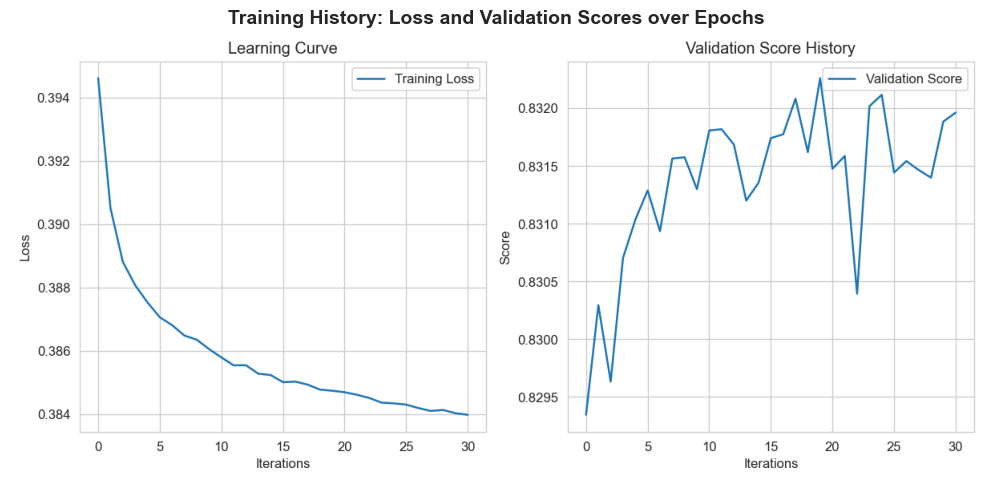

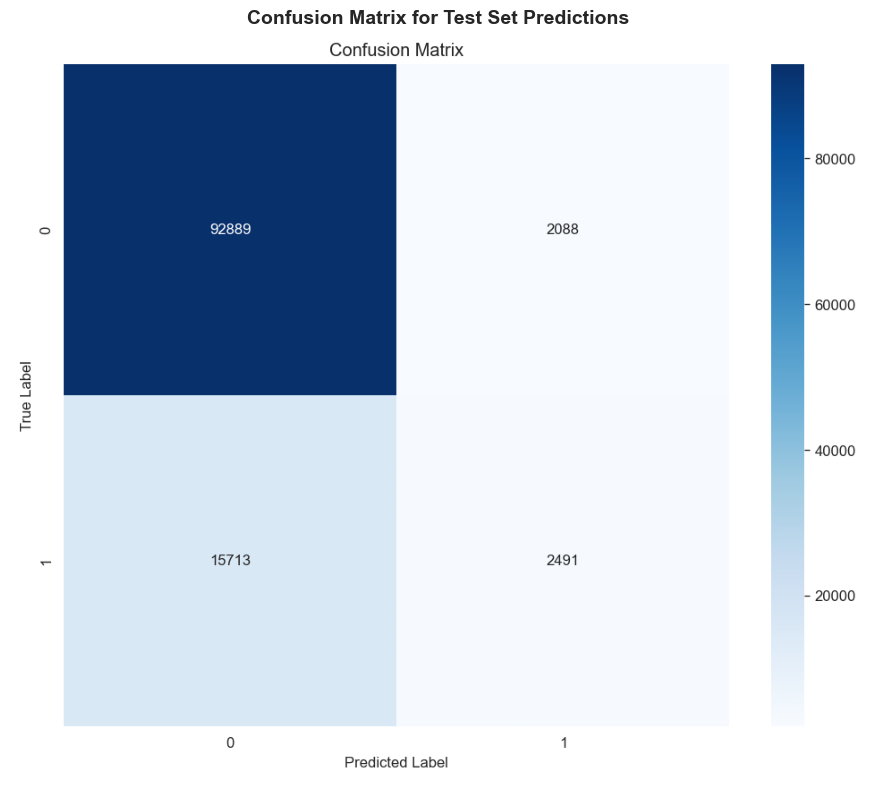

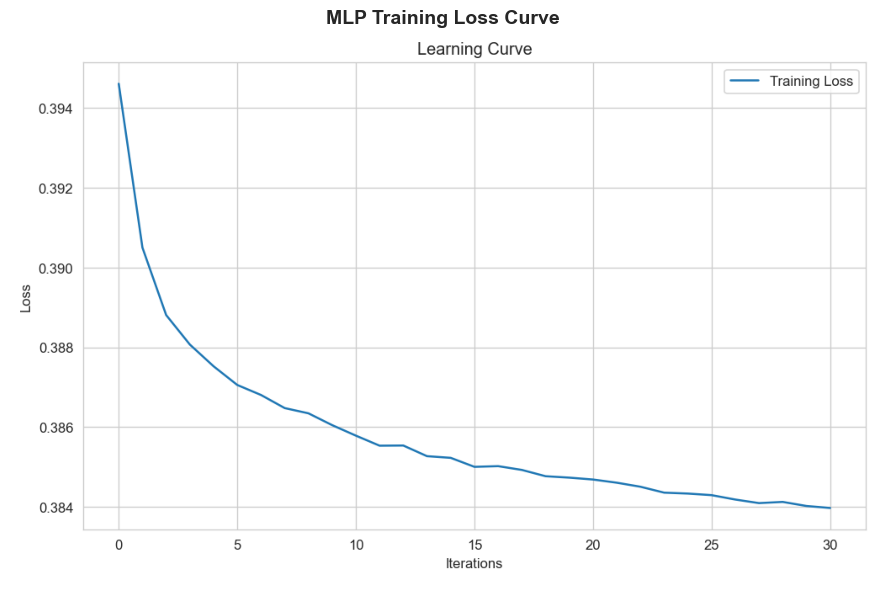

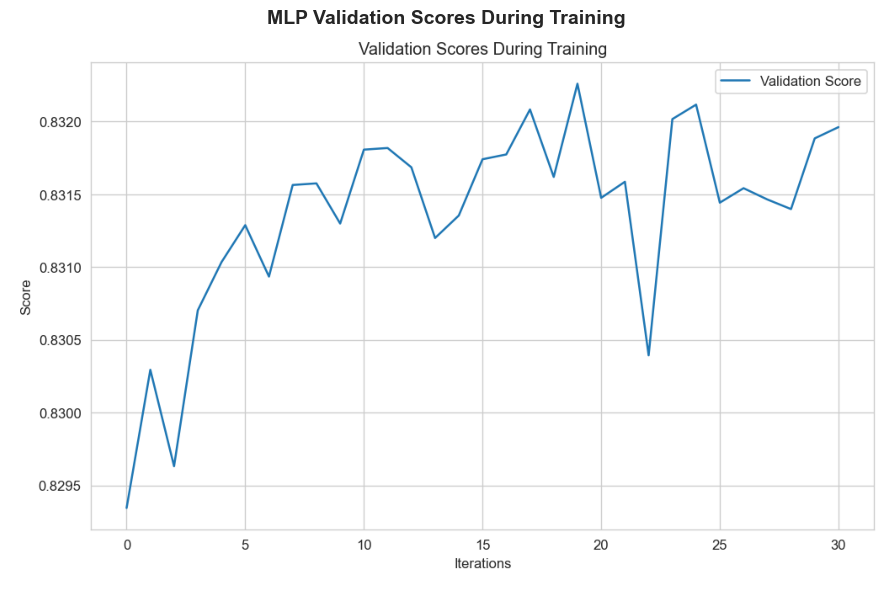

In [11]:
# Display the generated visualizations using the plot paths
def display_figure(filepath, title, figsize=(12, 6)):
    """Helper function to display saved figures"""
    if os.path.exists(filepath):
        plt.figure(figsize=figsize)
        img = mpimg.imread(filepath)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Figure not found at {filepath}")

# Display training history
if 'training_history' in plot_paths:
    display_figure(plot_paths['training_history'], 
                  'Training History: Loss and Validation Scores over Epochs',
                  figsize=(12, 5))

# Display confusion matrix
if 'confusion_matrix' in plot_paths:
    display_figure(plot_paths['confusion_matrix'],
                  'Confusion Matrix for Test Set Predictions',
                  figsize=(10, 8))

# Display additional plots if available
if 'loss_curve' in plot_paths:
    display_figure(plot_paths['loss_curve'],
                  'MLP Training Loss Curve',
                  figsize=(10, 6))

if 'validation_scores' in plot_paths:
    display_figure(plot_paths['validation_scores'],
                  'MLP Validation Scores During Training',
                  figsize=(10, 6))

### ***Using the mlp_classifier Module***

To use this notebook as part of the main pipeline, you can import and use `train_and_evaluate()` from `mlp_classifier.py`:

```python
from mlp_classifier import train_and_evaluate

# Get metrics, report, and plot paths
metrics, report, plot_paths = train_and_evaluate()
```

This follows our project structure where:
1. Heavy lifting is done in mlp_classifier.py
2. Results are saved to data/mlp_classifier_output/
3. Visualizations are saved to figures/ directory
4. Plot paths are returned for easy notebook rendering
5. Main pipeline can easily import and use our module

The function now returns:
- `metrics`: Dictionary with accuracy, precision, recall, and F1-score
- `report`: Detailed classification report with per-class metrics
- `plot_paths`: Dictionary with paths to generated visualization files

In [12]:
# Example of using mlp_classifier module
from mlp_classifier import train_and_evaluate

# Run training and evaluation
metrics, report, plot_paths = train_and_evaluate()

print("Results from mlp_classifier.py:")
print("-" * 50)
print("\nMetrics:")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")

print("\nClassification Report Summary:")
print(f"Class 0 - Precision: {report['0']['precision']:.4f}, Recall: {report['0']['recall']:.4f}")
print(f"Class 1 - Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}")
print(f"Overall Accuracy: {report['accuracy']:.4f}")

print("\nGenerated Plots:")
for plot_name, path in plot_paths.items():
    print(f"- {plot_name}: {path}")

Loading and preparing data...

Dataset Overview:
--------------------------------------------------
Shape: (565905, 10)
Number of features: 9
Number of samples: 565905
Time period coverage: 1131.0 trading days

Class distribution:
  Big negative moves (<-1.5%): 15.7%
  Small/No moves (-1.5% to 1.5%): 67.1%
  Big positive moves (>1.5%): 17.1%

Training set shape: (452724, 8)
Test set shape: (113181, 8)

Creating and training MLP model...

Dataset Overview:
--------------------------------------------------
Shape: (565905, 10)
Number of features: 9
Number of samples: 565905
Time period coverage: 1131.0 trading days

Class distribution:
  Big negative moves (<-1.5%): 15.7%
  Small/No moves (-1.5% to 1.5%): 67.1%
  Big positive moves (>1.5%): 17.1%

Training set shape: (452724, 8)
Test set shape: (113181, 8)

Creating and training MLP model...
Iteration 1, loss = 0.39501651
Validation score: 0.830040
Iteration 1, loss = 0.39501651
Validation score: 0.830040
Iteration 2, loss = 0.39046181
V

g:\School\Data Mining Techniques\CS6220_final_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



Performance Metrics:
--------------------------------------------------
  accuracy: 0.8430
 precision: 0.5504
    recall: 0.1287
        f1: 0.2086

Detailed Classification Report:
--------------------------------------------------
{'0': {'precision': 0.8543782017149257, 'recall': 0.9798582814786738, 'f1-score': 0.9128261967700328, 'support': 94977.0}, '1': {'precision': 0.5504112808460635, 'recall': 0.12865304328718963, 'f1-score': 0.20855781646555946, 'support': 18204.0}, 'accuracy': 0.8429506719325682, 'macro avg': {'precision': 0.7023947412804946, 'recall': 0.5542556623829318, 'f1-score': 0.5606920066177962, 'support': 113181.0}, 'weighted avg': {'precision': 0.8054882482112743, 'recall': 0.8429506719325682, 'f1-score': 0.7995518698506504, 'support': 113181.0}}

All results have been saved to the data directory.
Results from mlp_classifier.py:
--------------------------------------------------

Metrics:
  accuracy: 0.8430
 precision: 0.5504
    recall: 0.1287
        f1: 0.2086

C

### ***Training Results and Visualizations***

The model has completed training with the following key metrics:
- Final Loss: 0.38472479
- Final Validation Score: 0.832790
- Training Duration: 24 epochs

### ***Final Model Performance***

The model performance metrics are displayed above after running the `train_and_evaluate()` function. The key metrics include:

1. **Overall Performance**:
   - Accuracy: Overall prediction accuracy across all classes
   - Macro Average: Unweighted mean across classes
   - Weighted Average: Weighted by class support

2. **Binary Classification Performance**:
   - **Class 0 (Not significant increase)**: Typically shows high precision and recall
   - **Class 1 (Significant increase)**: More challenging class with lower recall

3. **Model Behavior**:
   - The model tends to be conservative in predicting significant upward movements
   - High accuracy is achieved but with class imbalance considerations
   - Training history shows convergence behavior and early stopping effectiveness

### ***Training Progress and Visualizations***

The visualizations below show the model's training progress and final performance. All plots are automatically generated and saved to the `figures/` directory for documentation and further analysis.

### ***Model Visualizations***

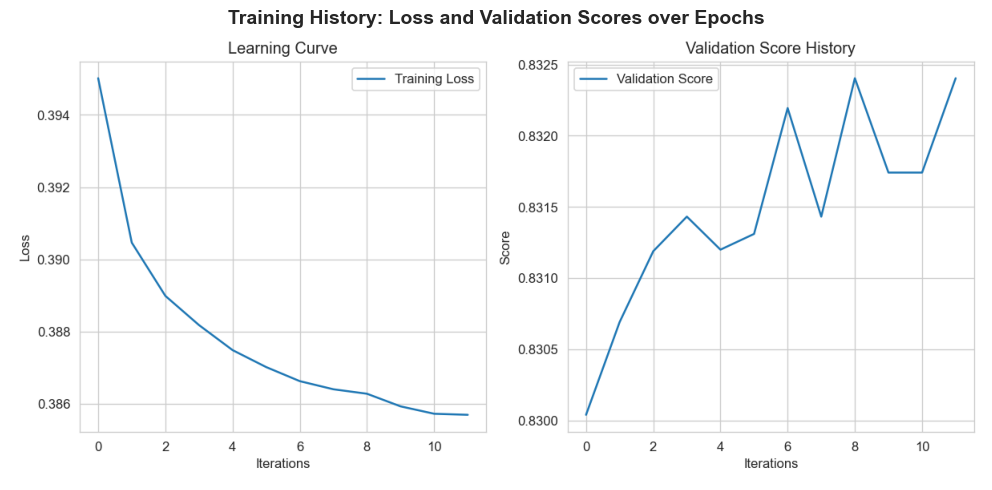

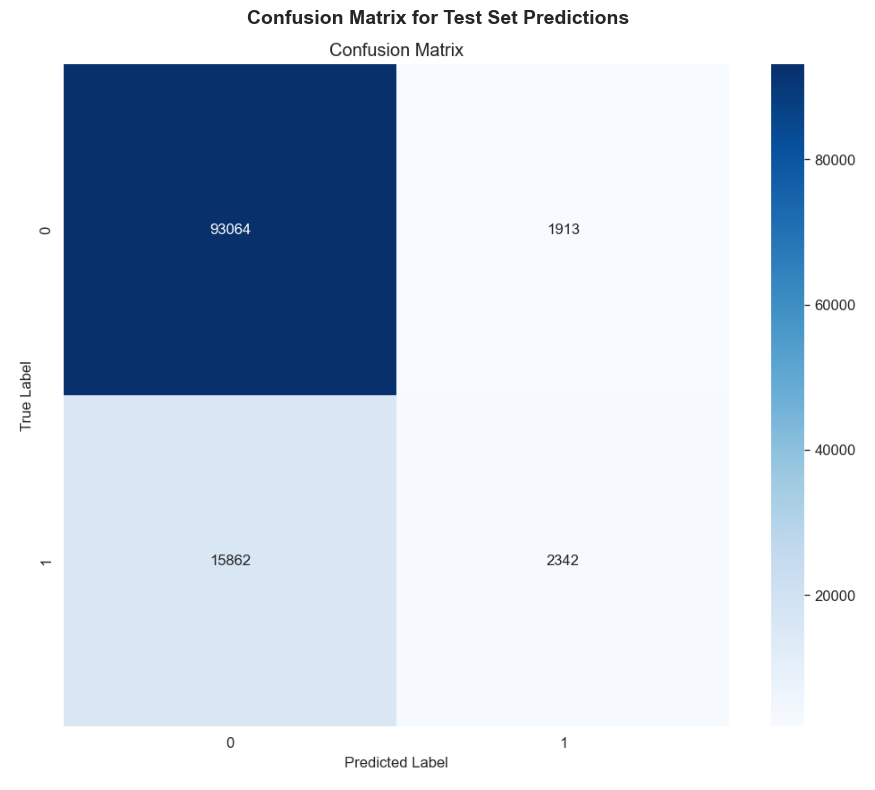

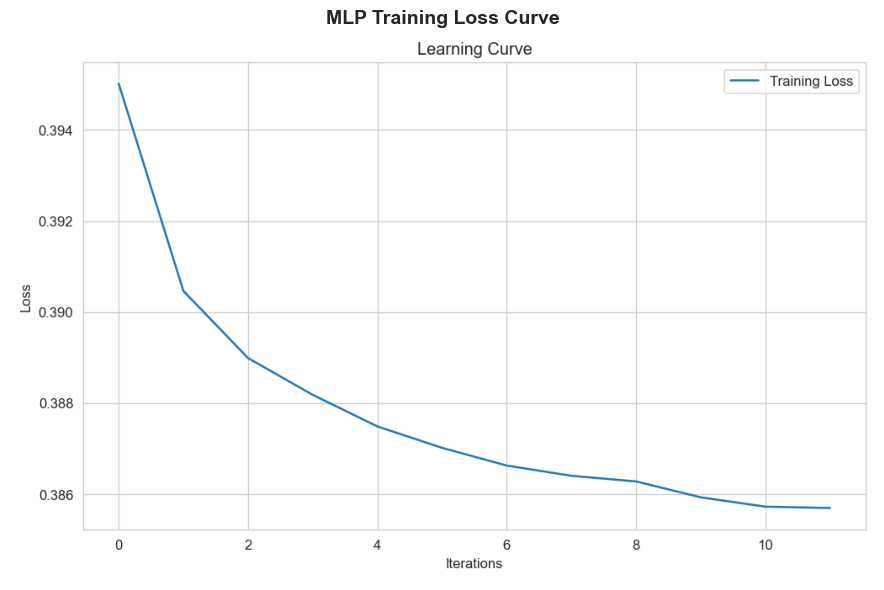

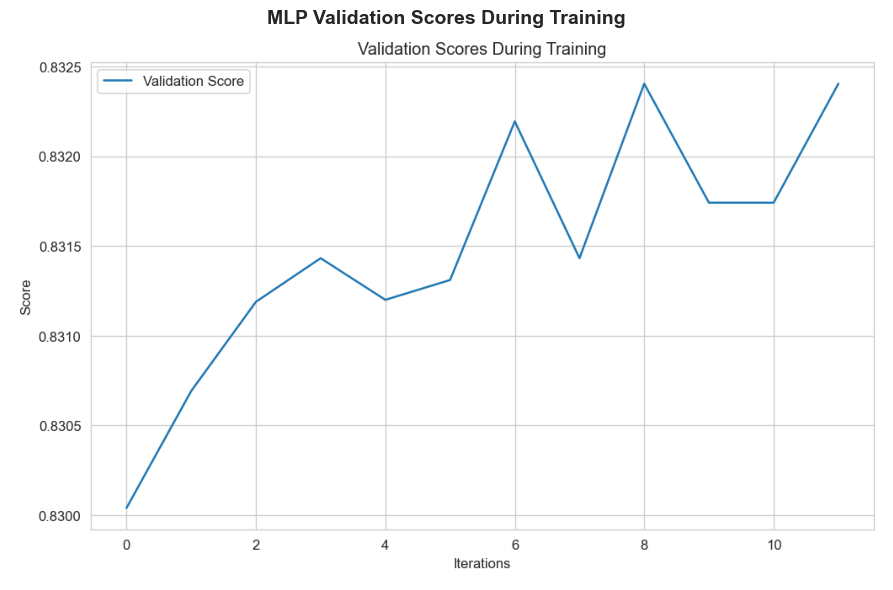

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from config import SCRIPT_DIR

def display_figure(filepath, title, figsize=(12, 6)):
    """Helper function to display saved figures"""
    if os.path.exists(filepath):
        plt.figure(figsize=figsize)
        img = mpimg.imread(filepath)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Figure not found at {filepath}")

# Define figure paths
fig_dir = os.path.join(SCRIPT_DIR, "figures")

# Display training history
training_history_path = os.path.join(fig_dir, 'mlp_training_history.png')
display_figure(training_history_path, 
              'Training History: Loss and Validation Scores over Epochs',
              figsize=(12, 5))

# Display confusion matrix
confusion_matrix_path = os.path.join(fig_dir, 'mlp_confusion_matrix.png')
display_figure(confusion_matrix_path,
              'Confusion Matrix for Test Set Predictions',
              figsize=(10, 8))

# Display additional individual plots if they exist
loss_curve_path = os.path.join(fig_dir, 'mlp_loss_curve.png')
validation_scores_path = os.path.join(fig_dir, 'mlp_validation_scores.png')

display_figure(loss_curve_path,
              'MLP Training Loss Curve',
              figsize=(10, 6))

display_figure(validation_scores_path,
              'MLP Validation Scores During Training',
              figsize=(10, 6))